In [3]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=False)

import os
import enum
import logging
import shutil, sys                                                                                                                                                    
import numpy as np
import tensorflow as tf
from matplotlib import pyplot
from keras import backend as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator

K.set_image_dim_ordering('th')



/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Using TensorFlow backend.


In [4]:
# Training Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 128
n_images = 5000

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

# Load the Mnist test data
xTest = mnist.test.images[:n_images]
yTest = list(mnist.test.labels[:n_images])
xTest = xTest.reshape(xTest.shape[0], 1, 28, 28)
# # convert from int to float
xTest = xTest.astype('float32')
xTestBackup = xTest.copy()
yTestBackup = yTest.copy()

xTrain = mnist.train.images[:10000]
yTrain = list(mnist.train.labels[:10000])
xTrain = xTrain.reshape(xTrain.shape[0], 1, 28, 28)
xTrain = xTrain.astype('float32')
xTrainBackup = xTrain.copy()
yTrainBackup = yTrain.copy()

In [5]:
Shade = "Shade"
Rotate = "Rotate"
Sheer = "Sheer"
Shift = "Shift"

Test = "Test"
Train = "Train"

In [6]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [7]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [8]:
def reloadData(dataType):
    if dataType == "Test": # Reset test data
        global xTest
        global yTest
        xTest[:] = xTestBackup
        yTest[:] = yTestBackup
    elif dataType == "Train": # Reset training data
        global xTrain
        global yTrain
        xTrain[:] = xTrainBackup
        yTrain[:] = yTrainBackup
        

In [9]:
def EvaluateModel(xData, yData, shuffle):
    input_fn = tf.estimator.inputs.numpy_input_fn(
            x={'images': xData}, y= np.array(yData),
            batch_size=batch_size, shuffle=shuffle)
    global model
    accuracy = model.evaluate(input_fn)
    return accuracy

In [10]:
# Build the Estimator
#model = tf.estimator.Estimator(model_fn)


In [11]:
def TrainModel( xTrain, yTrain, shuffle ):
    input_fn = tf.estimator.inputs.numpy_input_fn(
            x={'images': xTrain}, y= np.array(yTrain),
            batch_size=batch_size, shuffle=shuffle)
    global model
    # Train the Model
    model.train(input_fn, steps=num_steps)

In [12]:
def Transform( xData, yData, tType, value ):
    
    n_images = len(xData)
    
    # tType = 1 for shade
    if tType == "Shade":
        Xnew = [[[[v-value if v-value>0.0 else 0.0 for v in n] for n in x[0]]] for x in xData]
        Xnew = np.array(Xnew)
        xData[:] = Xnew.astype('float32')
        return;
        
    # tType = 2 for rotation
    if tType == "Rotate":
        datagen = ImageDataGenerator(rotation_range=value)# fit parameters from data
                
    # tType = 3 for sheer
    if tType == "Sheer":
        datagen = ImageDataGenerator(shear_range=value)# fit parameters from data
        
    # tType = 3 for shift
    if tType == "Shift":   
        datagen = ImageDataGenerator(width_shift_range=value, height_shift_range=value)
        
    datagen.fit(xData)
    # configure batch size and retrieve one batch of images
    for xBatch, yBatch in datagen.flow(xData, yData, batch_size=n_images, shuffle=False):
        xData[:] = xBatch
        yData[:] = yBatch
        break

In [13]:
def TestModel( xTest, yTest ):
    global model
    # Prepare the input data
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': xTest}, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))
    
    # Calculate the accuracy of model
    accuracy = EvaluateModel( xTest, yTest )
    return preds, accuracy

In [14]:
def DisplayData( xTest, yTest ):
    for i in range(len(xTest)):
        plt.imshow(np.reshape(xTest[i], [28, 28]), cmap='gray')
        plt.show()
        print ("Image Label: ", yTest[i])

In [43]:
def OpenFile(MT):
    filename = str(MT)+".txt"
    fp = open(filename, 'w')
    return fp

def CloseFile(fp):
    fp.close()
    
logging.getLogger("tensorflow").setLevel(logging.INFO)
#Shade = "Shade"
#Rotate = "Rotate"
#Sheer = "Sheer"
#Shift = "Shift"
def Perform (MT, fp, value, mode):
    
    if ( MT=="Shuffle" ):
        print ("Reloading training and test data")
        reloadData(Train)
        reloadData(Test)

        #print ("Training model")
        #TrainModel(xTrain, yTrain, model, True)
        
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest, True)
        print("Angle: ", value, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(value)+"\t"+str(accuracy['accuracy'])+"\n")
    
    if ( MT=="Rotate" ):
        print ("Reloading training data")
        reloadData(Train)
        print ("Transforming training data")
        Transform(xTrain, yTrain, Rotate, value)
        print ("Training model")
        TrainModel(xTrain, yTrain)
        print ("Reloading Test data")
        reloadData(Test)
        print ("Transforming testing Model")
        Transform(xTest, yTest, Rotate, value)
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest)
        print("Angle: ", value, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(value)+"\t"+str(accuracy['accuracy'])+"\n")
                
    if ( MT=="Shade" ):
        print ("Reloading training data")
        reloadData(Train)
        print ("Reloading Test data")
        reloadData(Test)
        
        if mode == Train or mode == "Both":
            print ("Transforming training data")
            Transform(xTrain, yTrain, Shade, value)
            print ("Training model")
            TrainModel(xTrain, yTrain, False)       
        if mode == Test or mode == "Both":
            print ("Transforming testing Model")
            Transform(xTest, yTest, Shade, value)
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest, False)
        print("Shade value: ", value, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(value)+"\t"+str(accuracy['accuracy'])+"\n")
    
    if ( MT=="Sheer" ):
        print ("Reloading training data")
        reloadData(Train)
        print ("Transforming training data")
        Transform(xTrain, yTrain, Sheer, value)
        print ("Training model")
        TrainModel(xTrain, yTrain)
        print ("Reloading Test data")
        reloadData(Test)
        print ("Transforming testing Model")
        Transform(xTest, yTest, Sheer, value)
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest)
        print("Sheer value: ", value, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(value)+"\t"+str(accuracy['accuracy'])+"\n")
        
    if ( MT=="Shift" ):
        value = 0.0
        for n in range(100):
            print ("Reset model")
            model = tf.estimator.Estimator(model_fn)
            print ("Reloading training data")
            reloadData(Train)
            print ("Transforming training data")
            value = n*0.005
            Transform(xTrain, yTrain, Shift, value)
            print ("Training model")
            TrainModel(xTrain, yTrain)
            print ("Reloading Test data")
            reloadData(Test)
            print ("Transforming testing Model")
            Transform(xTest, yTest, Shift, value)
            print ("Evaluating Model")
            accuracy = EvaluateModel(xTest, yTest)
            print("Shift value: ", value, " Accuracy: ", accuracy)
            if write==1:
                fp.write(str(value)+"\t"+str(accuracy['accuracy'])+"\n")

In [55]:
fp = OpenFile("Shade_"+str(Train))
model_dir = "models/Shade_"+str(Train)
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
for n in range(100):
    Perform(Shade, fp, n*0.005, Train)
    shutil.rmtree(model_dir)
CloseFile(fp)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/Shade_Train', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1cd3e53b00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_o

Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.2928936, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.21880874.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-03:56:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-03:56:29
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9258, global_step = 79, loss = 0.2545

INFO:tensorflow:Starting evaluation at 2019-06-18-04:02:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-04:02:52
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8948, global_step = 79, loss = 0.39818838
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.06  Accuracy:  {'accuracy': 0.8948, 'loss': 0.39818838, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/mod

Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.3009598, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.1689761.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-04:10:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-04:10:18
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8964, global_step = 79, loss = 0.33998

INFO:tensorflow:Starting evaluation at 2019-06-18-04:16:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-04:16:40
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9162, global_step = 79, loss = 0.28677255
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.125  Accuracy:  {'accuracy': 0.9162, 'loss': 0.28677255, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/mo

Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.2859526, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.03032713.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-04:23:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-04:24:03
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9222, global_step = 79, loss = 0.3352

INFO:tensorflow:Starting evaluation at 2019-06-18-04:30:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-04:30:23
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8888, global_step = 79, loss = 0.39440903
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.19  Accuracy:  {'accuracy': 0.8888, 'loss': 0.39440903, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/mod

Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.298426, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.11832904.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-04:37:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-04:37:46
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.918, global_step = 79, loss = 0.325369

INFO:tensorflow:Starting evaluation at 2019-06-18-04:44:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-04:44:05
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9132, global_step = 79, loss = 0.34379518
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.255  Accuracy:  {'accuracy': 0.9132, 'loss': 0.34379518, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/mo

Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.2876334, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.15041131.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-04:51:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-04:51:26
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.902, global_step = 79, loss = 0.40429

INFO:tensorflow:Starting evaluation at 2019-06-18-04:57:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-04:57:44
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9154, global_step = 79, loss = 0.49231988
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.32  Accuracy:  {'accuracy': 0.9154, 'loss': 0.49231988, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/mod

Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.2903934, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.06668744.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:05:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:05:06
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9122, global_step = 79, loss = 0.4871

INFO:tensorflow:Starting evaluation at 2019-06-18-05:11:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:11:23
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9142, global_step = 79, loss = 0.4874372
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.385  Accuracy:  {'accuracy': 0.9142, 'loss': 0.4874372, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/mode

Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.29818, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.37180492.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:18:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:18:44
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9096, global_step = 79, loss = 0.437164

INFO:tensorflow:Starting evaluation at 2019-06-18-05:24:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:25:01
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8776, global_step = 79, loss = 0.7143929
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.45  Accuracy:  {'accuracy': 0.8776, 'loss': 0.7143929, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model

Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.3097105, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.28362352.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:32:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:32:21
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9054, global_step = 79, loss = 0.4263

[0.9132, 0.91, 0.921, 0.9164, 0.9078, 0.905, 0.9258, 0.9108, 0.9084, 0.918, 0.921, 0.9106, 0.8948, 0.9352, 0.9132, 0.9184, 0.936, 0.9068, 0.9128, 0.8964, 0.9262, 0.9154, 0.8998, 0.9168, 0.9102, 0.9162, 0.917, 0.8864, 0.9182, 0.8928, 0.9262, 0.9182, 0.9222, 0.919, 0.8706, 0.9036, 0.9022, 0.9268, 0.8888, 0.9104, 0.8882, 0.9152, 0.9448, 0.8466, 0.901, 0.918, 0.9328, 0.9102, 0.9192, 0.9158, 0.921, 0.9132, 0.8888, 0.9324, 0.8988, 0.9278, 0.8948, 0.9126, 0.902, 0.9268, 0.8506, 0.9052, 0.9212, 0.9246, 0.9154, 0.9006, 0.923, 0.9244, 0.8972, 0.9126, 0.936, 0.9122, 0.9046, 0.9172, 0.9372, 0.913, 0.9274, 0.9142, 0.9116, 0.8992, 0.915, 0.8912, 0.9176, 0.9008, 0.9096, 0.9218, 0.938, 0.8452, 0.9222, 0.9028, 0.8776, 0.9222, 0.8586, 0.9002, 0.917, 0.9168, 0.9038, 0.9054, 0.8678, 0.88]


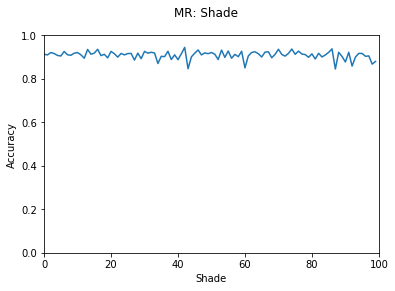

In [58]:
fp = open("Shade_Train.txt", 'r')
acc = []
for line in fp:
    line = line.strip()
    x = line.split("\t")
    acc.append(float(x[1]))
print(acc)
plt.axis([0, 100, 0, 1])
plt.plot(np.arange(0,100,1),acc)
plt.xlabel("Shade")
plt.ylabel("Accuracy")
plt.suptitle("MR: Shade")
plt.show()

In [56]:
fp = OpenFile("Shade_"+str(Test))
model_dir = "models/Shade_"+str(Test)
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
TrainModel(xTrain, yTrain, False)
for n in range(100):
    Perform(Shade, fp, n*0.005, Test)
CloseFile(fp)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/Shade_Test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1cde4e3048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Test/model.ckpt.
INFO:ten

INFO:tensorflow:Starting evaluation at 2019-06-18-05:37:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:37:29
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9216, global_step = 79, loss = 0.41919738
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.045  Accuracy:  {'accuracy': 0.9216, 'loss': 0.41919738, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:37:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done r

Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:40:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:40:06
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9234, global_step = 79, loss = 0.3895922
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.1  Accuracy:  {'accuracy': 0.9234, 'loss': 0.3895922, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:40:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/

Shade value:  0.15  Accuracy:  {'accuracy': 0.9248, 'loss': 0.37049538, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:42:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:42:43
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9252, global_step = 79, loss = 0.36601514
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.155  Accuracy:  {'accuracy': 0.9252, 'loss': 0.36601514, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Do

INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9258, global_step = 79, loss = 0.34475097
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.20500000000000002  Accuracy:  {'accuracy': 0.9258, 'loss': 0.34475097, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:45:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:45:24
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.926, global_step = 79, loss = 0.3410743
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:47:46
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9264, global_step = 79, loss = 0.32035252
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.26  Accuracy:  {'accuracy': 0.9264, 'loss': 0.32035252, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:47:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at

Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:50:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:50:22
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9254, global_step = 79, loss = 0.3001883
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.315  Accuracy:  {'accuracy': 0.9254, 'loss': 0.3001883, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:50:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.365  Accuracy:  {'accuracy': 0.9266, 'loss': 0.28623337, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:52:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:52:57
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9268, global_step = 79, loss = 0.28574535
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.37  Accuracy:  {'accuracy': 0.9268, 'loss': 0.28574535, 'global_step': 79}
Reloading training data
Reloading Test 

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:55:18
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9244, global_step = 79, loss = 0.27622524
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.42  Accuracy:  {'accuracy': 0.9244, 'loss': 0.27622524, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:55:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:55:32
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9242, global_step = 79, loss 

Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:57:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-05:57:52
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.922, global_step = 79, loss = 0.26825178
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.47500000000000003  Accuracy:  {'accuracy': 0.922, 'loss': 0.26825178, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-05:58:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring paramet

[0.92, 0.92, 0.9206, 0.9206, 0.9208, 0.921, 0.9212, 0.9214, 0.9214, 0.9216, 0.922, 0.9218, 0.9218, 0.9216, 0.922, 0.922, 0.9224, 0.9224, 0.923, 0.9232, 0.9234, 0.9232, 0.9236, 0.9236, 0.9238, 0.9244, 0.9244, 0.9246, 0.9246, 0.9248, 0.9248, 0.9252, 0.9254, 0.9258, 0.926, 0.9264, 0.9266, 0.9266, 0.9262, 0.926, 0.9264, 0.9258, 0.926, 0.9266, 0.9266, 0.9264, 0.9262, 0.9266, 0.9262, 0.926, 0.9266, 0.9262, 0.9264, 0.9264, 0.9264, 0.926, 0.9264, 0.9268, 0.9268, 0.9268, 0.926, 0.9258, 0.9254, 0.9254, 0.9262, 0.9262, 0.9268, 0.9266, 0.9266, 0.9266, 0.9268, 0.9264, 0.9264, 0.9266, 0.9268, 0.9264, 0.9266, 0.9266, 0.9264, 0.9262, 0.926, 0.9256, 0.9254, 0.925, 0.9244, 0.9242, 0.9238, 0.924, 0.9234, 0.9236, 0.9234, 0.9234, 0.923, 0.9226, 0.9218, 0.922, 0.9212, 0.9214, 0.9212, 0.9214]


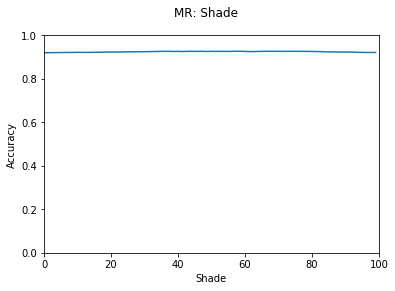

In [59]:
fp = open("Shade_Test.txt", 'r')
acc = []
for line in fp:
    line = line.strip()
    x = line.split("\t")
    acc.append(float(x[1]))
print(acc)
plt.axis([0, 100, 0, 1])
plt.plot(np.arange(0,100,1),acc)
plt.xlabel("Shade")
plt.ylabel("Accuracy")
plt.suptitle("MR: Shade")
plt.show()

In [57]:
fp = OpenFile("Shade_"+str("Both"))
model_dir = "models/Shade_"+str("Both")
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
for n in range(100):
    Perform(Shade, fp, n*0.005, "Both")
    shutil.rmtree(model_dir)
CloseFile(fp)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/Shade_Both', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1cde886b38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Both/model.ckpt-79
Shade value:  0.025  Accuracy:  {'accuracy': 0.9088, 'loss': 0.33973077, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Both/model.ckpt.
INFO:tensorflow:loss = 2.3129163, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.037531167.
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-06:07:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Both/model.ckpt.
INFO:tensorflow:loss = 2.3174093, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.15259406.
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-06:14:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-06:14:47
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9016, global_step = 79, loss = 0.33707228
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Both/model.ckpt-79
Shade value:  0.06  Accuracy:  {'accuracy': 0.9016, 'loss': 0.33707228, 'globa

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-06:22:07
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9248, global_step = 79, loss = 0.24642432
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Both/model.ckpt-79
Shade value:  0.09  Accuracy:  {'accuracy': 0.9248, 'loss': 0.24642432, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Both/model.ckpt.
INFO:tensorflow:loss = 2.3147938, step = 1
INFO:tenso

Shade value:  0.12  Accuracy:  {'accuracy': 0.908, 'loss': 0.36572987, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Both/model.ckpt.
INFO:tensorflow:loss = 2.3131132, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.22948012.
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-06:30:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:

INFO:tensorflow:loss = 2.300764, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.120355636.
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-06:37:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-06:37:56
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9364, global_step = 79, loss = 0.2165006
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Both/model.ckpt-79
Shade value:  0.155  Accuracy:  {'accuracy': 0.9364, 'loss': 0.2165006, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Callin

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-06:45:14
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9296, global_step = 79, loss = 0.25114188
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Both/model.ckpt-79
Shade value:  0.185  Accuracy:  {'accuracy': 0.9296, 'loss': 0.25114188, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Both/model.ckpt.
INFO:tensorflow:loss = 2.3003864, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.1597

Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Both/model.ckpt.
INFO:tensorflow:loss = 2.3101618, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0471085.
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-06:53:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-06:53:44
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9072, global_s

INFO:tensorflow:Loss for final step: 0.05767441.
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-07:01:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-07:01:06
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8878, global_step = 79, loss = 0.3774873
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Both/model.ckpt-79
Shade value:  0.25  Accuracy:  {'accuracy': 0.8878, 'loss': 0.3774873, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was 

INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8962, global_step = 79, loss = 0.36916274
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Both/model.ckpt-79
Shade value:  0.28  Accuracy:  {'accuracy': 0.8962, 'loss': 0.36916274, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Both/model.ckpt.
INFO:tensorflow:loss = 2.3115683, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.18211538.
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Star

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Both/model.ckpt.
INFO:tensorflow:loss = 2.2939837, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.21659917.
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-07:16:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-07:16:50
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.903, global_step = 79, loss = 0.30192336
INFO:tensorflow:Saving 'checkpoint_path' summary for global 

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-07:24:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-07:24:05
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9108, global_step = 79, loss = 0.3132759
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Both/model.ckpt-79
Shade value:  0.34500000000000003  Accuracy:  {'accuracy': 0.9108, 'loss': 0.3132759, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Sa

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Both/model.ckpt-79
Shade value:  0.375  Accuracy:  {'accuracy': 0.9296, 'loss': 0.24072635, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Both/model.ckpt.
INFO:tensorflow:loss = 2.3027928, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.11752012.
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-07:32:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring 

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Both/model.ckpt.
INFO:tensorflow:loss = 2.315529, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.24107677.
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-07:39:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-07:39:45
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9136, global_step = 79, loss = 0.29216775
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Both/model.ckpt-79
Shade value:  0.41000000000000003  Accuracy:  {'accuracy': 0.9136, 'loss': 0.29

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-07:46:59
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.89, global_step = 79, loss = 0.35096815
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Both/model.ckpt-79
Shade value:  0.44  Accuracy:  {'accuracy': 0.89, 'loss': 0.35096815, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Both/model.ckpt.
INFO:tensorflow:loss = 2.2995186, step = 1
INFO:tensorflo

Shade value:  0.47000000000000003  Accuracy:  {'accuracy': 0.9168, 'loss': 0.29560882, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Both/model.ckpt.
INFO:tensorflow:loss = 2.2990491, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.14226125.
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-07:55:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.


[0.9194, 0.8984, 0.9104, 0.8598, 0.914, 0.9088, 0.9256, 0.9162, 0.8866, 0.901, 0.9232, 0.8972, 0.9016, 0.9056, 0.9232, 0.9258, 0.891, 0.928, 0.9248, 0.917, 0.8934, 0.8786, 0.9038, 0.8984, 0.908, 0.9236, 0.9326, 0.9024, 0.8814, 0.9234, 0.8968, 0.9364, 0.8958, 0.9046, 0.8994, 0.9332, 0.895, 0.9296, 0.888, 0.932, 0.918, 0.914, 0.9212, 0.904, 0.9072, 0.9214, 0.904, 0.9088, 0.9148, 0.919, 0.8878, 0.926, 0.9186, 0.9396, 0.915, 0.91, 0.8962, 0.9168, 0.91, 0.8996, 0.7958, 0.9112, 0.933, 0.903, 0.896, 0.9062, 0.9006, 0.9052, 0.9148, 0.9108, 0.893, 0.9232, 0.8952, 0.8888, 0.9058, 0.9296, 0.9324, 0.9204, 0.903, 0.9136, 0.9264, 0.9038, 0.9136, 0.906, 0.9304, 0.9234, 0.9174, 0.9214, 0.89, 0.9156, 0.9274, 0.9076, 0.901, 0.8936, 0.9168, 0.8828, 0.8982, 0.9176, 0.9182, 0.8974]


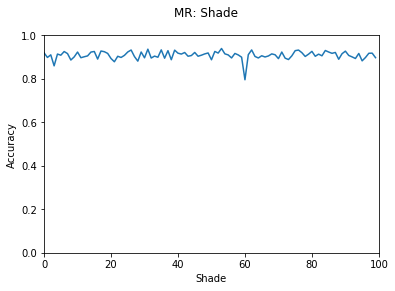

In [60]:
fp = open("Shade_Both.txt", 'r')
acc = []
for line in fp:
    line = line.strip()
    x = line.split("\t")
    acc.append(float(x[1]))
print(acc)
plt.axis([0, 100, 0, 1])
plt.plot(np.arange(0,100,1),acc)
plt.xlabel("Shade")
plt.ylabel("Accuracy")
plt.suptitle("MR: Shade")
plt.show()

In [16]:
def ShuffleMT (mode, fp, iteration):
    
    if (mode==Train):
        print ("Reloading training and test data")
        reloadData(Train)
        reloadData(Test)

        print ("Training model")
        TrainModel(xTrain, yTrain, True)
        
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest, False)
        print("Iteration: ", iteration, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(iteration)+"\t"+str(accuracy['accuracy'])+"\n")
            
    elif (mode==Test):
        print ("Reloading training and test data")
        reloadData(Train)
        reloadData(Test)
        
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest, True)
        print("Iteration: ", iteration, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(iteration)+"\t"+str(accuracy['accuracy'])+"\n")
            
    elif (mode=="Both"):
        print ("Reloading training and test data")
        reloadData(Train)
        reloadData(Test)

        print ("Training model")
        TrainModel(xTrain, yTrain, True)
        
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest, True)
        print("Iteration: ", iteration, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(iteration)+"\t"+str(accuracy['accuracy'])+"\n")

In [17]:
fp = OpenFile("Shuffle_"+str(Train))
model_dir = "models/Shuffle_"+str(Train)
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
for n in range(100):
    ShuffleMT(Train, fp, n)
    shutil.rmtree(model_dir)
CloseFile(fp)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/Shuffle_Train', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c368eaf98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Train/model.ckpt-0
INFO:tensorflow:Running local_init_op.
I

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:loss = 2.3127437, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.3797195.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-16-23:59:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-16-23:59:51
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9242, global_step = 79, loss = 0.26318294
INFO:tensorflow:Saving 'checkpoint_path

INFO:tensorflow:Finished evaluation at 2019-06-17-00:04:29
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9076, global_step = 79, loss = 0.31220335
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Train/model.ckpt-79
Iteration:  12  Accuracy:  {'accuracy': 0.9076, 'loss': 0.31220335, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:loss = 2.296404, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.026429309.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Start

INFO:tensorflow:Loss for final step: 0.11967678.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-00:09:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-00:09:54
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.918, global_step = 79, loss = 0.27754325
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Train/model.ckpt-79
Iteration:  19  Accuracy:  {'accuracy': 0.918, 'loss': 0.27754325, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorfl

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:loss = 2.2999146, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.4119171.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-00:15:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-00:15:21
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8824, global_step = 79, loss = 0.40515813
INFO:tensorflow:Saving 'checkpoint_path

INFO:tensorflow:Finished evaluation at 2019-06-17-00:19:59
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.91, global_step = 79, loss = 0.3042637
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Train/model.ckpt-79
Iteration:  32  Accuracy:  {'accuracy': 0.91, 'loss': 0.3042637, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:loss = 2.2940555, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.2016046.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting eva

INFO:tensorflow:Loss for final step: 2.277904.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-00:25:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-00:25:25
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.1, global_step = 79, loss = 2.3071659
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Train/model.ckpt-79
Iteration:  39  Accuracy:  {'accuracy': 0.1, 'loss': 2.3071659, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done 

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:loss = 2.3022435, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.43689236.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-00:30:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-00:30:50
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9158, global_step = 79, loss = 0.2834968
INFO:tensorflow:Saving 'checkpoint_path

INFO:tensorflow:Finished evaluation at 2019-06-17-00:35:27
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9254, global_step = 79, loss = 0.25184622
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Train/model.ckpt-79
Iteration:  52  Accuracy:  {'accuracy': 0.9254, 'loss': 0.25184622, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:loss = 2.324136, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.5194873.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Startin

INFO:tensorflow:Loss for final step: 0.55106896.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-00:40:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-00:40:53
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8974, global_step = 79, loss = 0.3254815
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Train/model.ckpt-79
Iteration:  59  Accuracy:  {'accuracy': 0.8974, 'loss': 0.3254815, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorfl

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:loss = 2.3071475, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.37623164.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-00:46:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-00:46:18
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.918, global_step = 79, loss = 0.2952714
INFO:tensorflow:Saving 'checkpoint_path'

INFO:tensorflow:Finished evaluation at 2019-06-17-00:50:58
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9114, global_step = 79, loss = 0.3016572
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Train/model.ckpt-79
Iteration:  72  Accuracy:  {'accuracy': 0.9114, 'loss': 0.3016572, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:loss = 2.2985868, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.1311429.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting

INFO:tensorflow:Loss for final step: 0.40504193.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-00:56:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-00:56:20
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8986, global_step = 79, loss = 0.36717218
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Train/model.ckpt-79
Iteration:  79  Accuracy:  {'accuracy': 0.8986, 'loss': 0.36717218, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensor

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:loss = 2.293163, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.077220604.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:01:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:01:43
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.931, global_step = 79, loss = 0.24596894
INFO:tensorflow:Saving 'checkpoint_path

INFO:tensorflow:Finished evaluation at 2019-06-17-01:06:20
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.925, global_step = 79, loss = 0.2541275
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Train/model.ckpt-79
Iteration:  92  Accuracy:  {'accuracy': 0.925, 'loss': 0.2541275, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:loss = 2.28609, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.2816688.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting eva

INFO:tensorflow:Loss for final step: 0.40328687.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:11:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:11:42
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8416, global_step = 79, loss = 0.51717234
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Train/model.ckpt-79
Iteration:  99  Accuracy:  {'accuracy': 0.8416, 'loss': 0.51717234, 'global_step': 79}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/Shuffle_Test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_ke

NameError: name 'shuffleMT' is not defined

[0.9274, 0.9002, 0.9384, 0.8974, 0.933, 0.9114, 0.9242, 0.9164, 0.9262, 0.9086, 0.9026, 0.904, 0.9076, 0.8884, 0.8994, 0.9264, 0.9366, 0.9012, 0.8974, 0.918, 0.9234, 0.9272, 0.8856, 0.913, 0.8448, 0.8886, 0.8824, 0.8848, 0.917, 0.9378, 0.9276, 0.9144, 0.91, 0.9094, 0.937, 0.9172, 0.906, 0.9302, 0.9186, 0.1, 0.1142, 0.9234, 0.8586, 0.927, 0.9298, 0.9352, 0.9158, 0.9254, 0.9316, 0.9278, 0.919, 0.861, 0.9254, 0.9276, 0.927, 0.9288, 0.9042, 0.9268, 0.9238, 0.8974, 0.9342, 0.9248, 0.934, 0.931, 0.9346, 0.8964, 0.918, 0.9026, 0.9302, 0.9282, 0.8988, 0.8638, 0.9114, 0.9004, 0.927, 0.9146, 0.918, 0.9202, 0.915, 0.8986, 0.8952, 0.926, 0.9104, 0.8856, 0.9284, 0.9288, 0.931, 0.9128, 0.93, 0.9048, 0.9286, 0.9092, 0.925, 0.9218, 0.9222, 0.9108, 0.903, 0.9208, 0.9368, 0.8416]


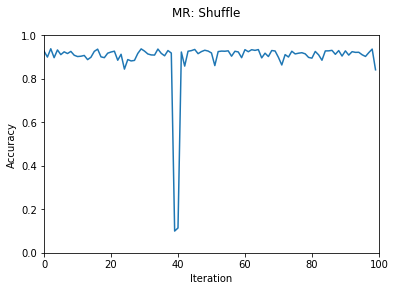

In [40]:
fp = open("Shuffle_Train.txt", 'r')
acc = []
for line in fp:
    line = line.strip()
    x = line.split("\t")
    acc.append(float(x[1]))
print(acc)
plt.axis([0, 100, 0, 1])
plt.plot(np.arange(0,100,1),acc)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.suptitle("MR: Shuffle")
plt.show()

In [20]:
fp = OpenFile("Shuffle_"+str(Test))
model_dir = "models/Shuffle_"+str(Test)
shutil.rmtree(model_dir)
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
TrainModel(xTrain, yTrain, False)
for n in range(100):
    ShuffleMT(Test, fp, n)
CloseFile(fp)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/Shuffle_Test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c8ffe17f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Test/model.ckpt.
INFO

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Test/model.ckpt-79
Iteration:  9  Accuracy:  {'accuracy': 0.9274, 'loss': 0.2560153, 'global_step': 79}
Reloading training and test data
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:19:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:19:05
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9274, global_step = 79, loss = 0.26496106
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Test/model.ckpt-79
Iteration:  10  Accuracy:  {'accuracy': 0.9274, 'loss': 0.26496106, 'global_step': 79}
Reloading training and test data
Evaluating Model
INFO:tensorflow:Calling model_fn

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:19:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:19:55
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9274, global_step = 79, loss = 0.25493005
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Test/model.ckpt-79
Iteration:  21  Accuracy:  {'accuracy': 0.9274, 'loss': 0.25493005, 'global_step': 79}
Reloading training and test data
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:19:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:20:49
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9274, global_step = 79, loss = 0.2576305
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Test/model.ckpt-79
Iteration:  32  Accuracy:  {'accuracy': 0.9274, 'loss': 0.2576305, 'global_step': 79}
Reloading training and test data
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:20:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:20:54
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9274, global_step = 79, loss = 0.25616568
INFO:tensorflow:Saving 'che

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Test/model.ckpt-79
Iteration:  43  Accuracy:  {'accuracy': 0.9274, 'loss': 0.25607812, 'global_step': 79}
Reloading training and test data
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:21:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:21:41
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9274, global_step = 79, loss = 0.26640105
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Test/model.ckpt-79
Iteration:  44  Accuracy:  {'accuracy': 0.9274, 'loss': 0.26640105, 'global_step': 79}
Reloading training and test data
Evaluating Model
INFO:tensorflow:Calling model_

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:22:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:22:28
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9274, global_step = 79, loss = 0.2636062
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Test/model.ckpt-79
Iteration:  55  Accuracy:  {'accuracy': 0.9274, 'loss': 0.2636062, 'global_step': 79}
Reloading training and test data
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:22:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done r

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:23:15
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9274, global_step = 79, loss = 0.25807872
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Test/model.ckpt-79
Iteration:  66  Accuracy:  {'accuracy': 0.9274, 'loss': 0.25807872, 'global_step': 79}
Reloading training and test data
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:23:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:23:19
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9274, global_step = 79, loss = 0.2586809
INFO:tensorflow:Saving 'ch

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Test/model.ckpt-79
Iteration:  77  Accuracy:  {'accuracy': 0.9274, 'loss': 0.25647312, 'global_step': 79}
Reloading training and test data
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:24:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:24:06
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9274, global_step = 79, loss = 0.27856722
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Test/model.ckpt-79
Iteration:  78  Accuracy:  {'accuracy': 0.9274, 'loss': 0.27856722, 'global_step': 79}
Reloading training and test data
Evaluating Model
INFO:tensorflow:Calling model_

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:24:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:24:55
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9274, global_step = 79, loss = 0.25719538
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Test/model.ckpt-79
Iteration:  89  Accuracy:  {'accuracy': 0.9274, 'loss': 0.25719538, 'global_step': 79}
Reloading training and test data
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:24:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done

[0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274]


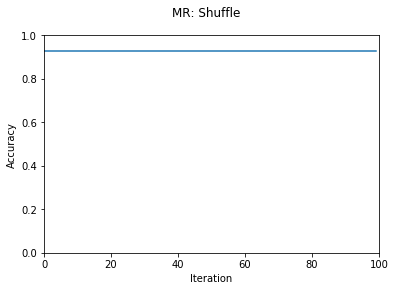

In [41]:
fp = open("Shuffle_Test.txt", 'r')
acc = []
for line in fp:
    line = line.strip()
    x = line.split("\t")
    acc.append(float(x[1]))
print(acc)
plt.axis([0, 100, 0, 1])
plt.plot(np.arange(0,100,1),acc)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.suptitle("MR: Shuffle")
plt.show()

In [21]:
fp = OpenFile("Shuffle_"+str("Both"))
model_dir = "models/Shuffle_"+str("Both")
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
for n in range(100):
    ShuffleMT("Both", fp, n)
    shutil.rmtree(model_dir)
CloseFile(fp)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/Shuffle_Both', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c90f3f438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:loss = 2.3199291, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.25417727.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:31:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:31:08
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8438, global_step = 79, loss = 0.5510335
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Both/model.ckpt-79
Iteration:  6  Accurac

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Both/model.ckpt-79
Iteration:  12  Accuracy:  {'accuracy': 0.9084, 'loss': 0.3222138, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:loss = 2.3160894, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.29853013.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:36:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Both/model.ckpt-79
INFO:tensorflow

INFO:tensorflow:Starting evaluation at 2019-06-17-01:41:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:41:04
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.892, global_step = 79, loss = 0.36121076
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Both/model.ckpt-79
Iteration:  19  Accuracy:  {'accuracy': 0.892, 'loss': 0.36121076, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:loss = 2.3026433

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:loss = 2.3049142, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.24242374.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:46:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:46:26
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9358, global_step = 79, loss = 0.22853816
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Both/model.ckpt-79
Iteration:  26  Accuracy:  {'accuracy': 0.9358, 'loss': 0.22853816, 'global_step': 79}
Reloading 

Iteration:  32  Accuracy:  {'accuracy': 0.9298, 'loss': 0.25133568, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:loss = 2.2919226, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.5414887.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-01:51:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-01:56:25
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9042, global_step = 79, loss = 0.3209241
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Both/model.ckpt-79
Iteration:  39  Accuracy:  {'accuracy': 0.9042, 'loss': 0.3209241, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:loss = 2.3116565, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.08315474.
Evaluating Model
INFO:tensorflow:

INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.2081447.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-02:01:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-02:01:53
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.927, global_step = 79, loss = 0.25013185
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Both/model.ckpt-79
Iteration:  46  Accuracy:  {'accuracy': 0.927, 'loss': 0.25013185, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorfl

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:loss = 2.3106043, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.067865975.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-02:07:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-02:07:21
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8794, global_step = 79, loss = 0.41144365
INFO:tensorflow:Saving 'checkpoint_path'

INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9126, global_step = 79, loss = 0.31250316
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Both/model.ckpt-79
Iteration:  59  Accuracy:  {'accuracy': 0.9126, 'loss': 0.31250316, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:loss = 2.3127162, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.032628827.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-02:12:23
INFO:tensorflow:Graph w

Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-02:16:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-02:16:47
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8928, global_step = 79, loss = 0.41480368
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Both/model.ckpt-79
Iteration:  66  Accuracy:  {'accuracy': 0.8928, 'loss': 0.41480368, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Sa

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:loss = 2.3044434, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.039549716.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-02:21:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-02:21:49
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9236, global_step = 79, loss = 0.277289
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Both/model.ckpt-79
Iteration:  73  Accura

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Both/model.ckpt-79
Iteration:  79  Accuracy:  {'accuracy': 0.9322, 'loss': 0.2392656, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:loss = 2.324994, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.13097425.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-02:26:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Both/model.ckpt-79
INFO:tensorflow:

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-02:31:10
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8814, global_step = 79, loss = 0.42531434
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Both/model.ckpt-79
Iteration:  86  Accuracy:  {'accuracy': 0.8814, 'loss': 0.42531434, 'global_step': 79}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:loss = 2.3217592, step = 1
INFO:tensorflow:Saving checkpoints for 79 into

INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:loss = 2.302236, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Both/model.ckpt.
INFO:tensorflow:Loss for final step: 0.15090656.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17-02:36:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Both/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-02:36:11
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.929, global_step = 79, loss = 0.24815127
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shuffle_Both/model.ckpt-79
Iteration:  93  Accuracy:  {'accuracy': 0.929, 'loss': 0.24815127, 'global_step': 79}
Reloading training and test data
Training model
INFO:tens

Iteration:  99  Accuracy:  {'accuracy': 0.8876, 'loss': 0.35114455, 'global_step': 79}


[0.9088, 0.9104, 0.9104, 0.9272, 0.9232, 0.8898, 0.8438, 0.908, 0.915, 0.9188, 0.891, 0.9114, 0.9084, 0.9228, 0.9228, 0.9168, 0.9244, 0.936, 0.9058, 0.892, 0.8604, 0.9184, 0.9196, 0.9036, 0.913, 0.9284, 0.9358, 0.9082, 0.9332, 0.9268, 0.876, 0.9174, 0.9298, 0.9146, 0.863, 0.9068, 0.912, 0.927, 0.8626, 0.9042, 0.9266, 0.934, 0.9238, 0.92, 0.9174, 0.9272, 0.927, 0.873, 0.919, 0.9306, 0.9156, 0.9154, 0.926, 0.8794, 0.9208, 0.9124, 0.9048, 0.931, 0.9112, 0.9126, 0.9156, 0.9302, 0.9104, 0.8842, 0.918, 0.9052, 0.8928, 0.907, 0.919, 0.9336, 0.928, 0.9234, 0.911, 0.9236, 0.919, 0.8734, 0.9052, 0.923, 0.9278, 0.9322, 0.9114, 0.903, 0.9092, 0.9078, 0.9056, 0.904, 0.8814, 0.8826, 0.9144, 0.9282, 0.9006, 0.8972, 0.932, 0.929, 0.931, 0.8964, 0.9376, 0.917, 0.921, 0.8876]


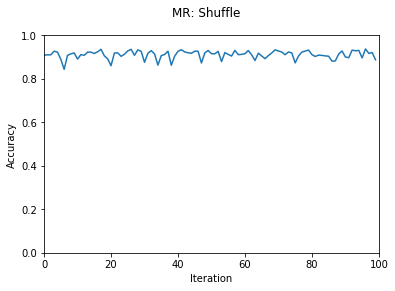

In [42]:
fp = open("Shuffle_Both.txt", 'r')
acc = []
for line in fp:
    line = line.strip()
    x = line.split("\t")
    acc.append(float(x[1]))
print(acc)
plt.axis([0, 100, 0, 1])
plt.plot(np.arange(0,100,1),acc)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.suptitle("MR: Shuffle")
plt.show()